In [1]:
# DB Connection
import sqlite3

# Casual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# For Random Forest
from sklearn.ensemble import RandomForestClassifier

# NLTK
import nltk

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
import re

# Wordcloud
from wordcloud import WordCloud,STOPWORDS

# Train - Test Split
from sklearn.model_selection import train_test_split

# Testing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dump Models
import pickle

In [6]:
#################### SZÖVEGELEMZÉS (KATEGÓRIA PREDIKTÁLÁS, ÉRZELEM OSZTÁLYOZÁS) ####################

In [3]:
# Adatbázis

connection = sqlite3.connect("podcasts.db")

In [8]:
#################### 1. KATEGÓRIA PREDIKCIÓ - TELJES ####################

In [9]:
# Adat betöltés

full_cat_pred = pd.read_sql("select reviews.content, categories.category from reviews, categories where reviews.podcast_id = categories.podcast_id", connection)
full_cat_pred_content = full_cat_pred['content'].values.tolist()
full_cat_pred_category = full_cat_pred['category'].values.tolist()

In [10]:
# Tanulás

fullcatpred = make_pipeline(TfidfVectorizer(), MultinomialNB())
fullcatpred.fit(full_cat_pred_content, full_cat_pred_category)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [11]:
# Prediktálás

def predict_category_full(s):
    pred = fullcatpred.predict([s])
    return pred

print(predict_category_full('bank system, valuta, credit card'))

['business']


In [12]:
# Mentés

pickle.dump(fullcatpred, open('fullcatpred.pkl','wb'))

In [13]:
#################### 2. KATEGÓRIA PREDIKCIÓ - RÉSZLEGES ####################

In [14]:
# Adat betöltés

par_cat_pred = pd.read_sql("select reviews.content, categories.category from reviews, categories where reviews.podcast_id = categories.podcast_id", connection)

In [15]:
# Szelektálás

categories = ['technology', 'arts-food','hinduism', 'spirituality']

def decision_maker(subject, categories):
    x = False
    for cat in categories:
        if subject == cat:
            x = True  
    return x

par_cat_pred_content = []
par_cat_pred_category = []

for ind in par_cat_pred.index:
    if (decision_maker(par_cat_pred['category'][ind], categories)):
        par_cat_pred_content.append(par_cat_pred['content'][ind])
        par_cat_pred_category.append(par_cat_pred['category'][ind])

In [16]:
# Tanulás

parcatpred = make_pipeline(TfidfVectorizer(), MultinomialNB())
parcatpred.fit(par_cat_pred_content, par_cat_pred_category)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [17]:
# Prediktálás

def predict_category_par(s):
    pred = parcatpred.predict([s])
    return pred

print(predict_category_par('hamburger, tasty, cheese, milk'))

['arts-food']


In [18]:
# Mentés

# Web alkalmazás logika

In [19]:
#################### 3. ÉRZELEM OSZTÁLYOZÁS ####################
# https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/

In [4]:
# Adat betöltés

sentiment_data = pd.read_sql("""
    select
        content,
        case when rating < 5 then 0
            when rating > 4 then 1
        end as sentiment
    from reviews
""", connection)

sentiment_data.sentiment.value_counts()

1    996894
0    151320
Name: sentiment, dtype: int64

In [5]:
# Adat csökkentés

sentiment_data_positive = sentiment_data[sentiment_data['sentiment'] == 1].head(150000)
sentiment_data_negative = sentiment_data[sentiment_data['sentiment'] == 0].head(150000)

frames = [sentiment_data_positive, sentiment_data_negative]

sentiment = pd.concat(frames, ignore_index=True)
features = sentiment.content
labels = sentiment.sentiment

In [6]:
# Tisztítás

processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [7]:
# TF - IDF

vectorizer = TfidfVectorizer (max_features=200, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [8]:
# TF - IDF Mentés

pickle.dump(vectorizer, open('tfidf.pkl','wb'))

In [9]:
# Train - Test Split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.05, random_state=0)

In [10]:
# Tanulás

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [11]:
# Model Mentés

pickle.dump(text_classifier, open('textclassifier.pkl','wb'))

In [12]:
# Tesztelés

predictions = text_classifier.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[5822 1625]
 [1730 5823]]
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      7447
           1       0.78      0.77      0.78      7553

    accuracy                           0.78     15000
   macro avg       0.78      0.78      0.78     15000
weighted avg       0.78      0.78      0.78     15000

0.7763333333333333


In [37]:
#################### 3. ÉRZELEM OSZTÁLYOZÁS ####################
# https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis/data

In [49]:
# Train - Test Split

train, test = train_test_split(sentiment_data,test_size = 0.1)

,content,sentiment
999346,I truly enjoy this podcast. I love that it’s a...,2
316096,Terrific podcast. Love it.,2
802235,I love Shannon's interpretation of her father'...,2
313060,War College is direct and to the point. I like...,2
1002477,From the minute I discovered your podcast bing...,2


In [56]:
# Szófelhő

train_pos = train[ train['sentiment'] == 2]
train_pos = train_pos['content']
train_neg = train[ train['sentiment'] == 0]
train_neg = train_neg['content']
train_neu = train[ train['sentiment'] == 1]
train_neu = train_neu['content']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


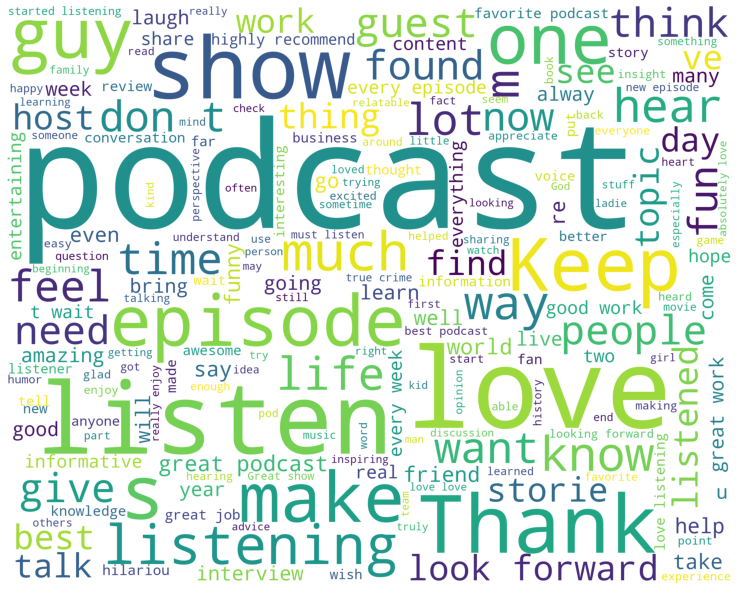

In [57]:
# Pozitív szavak

print("Positive words")
wordcloud_draw(train_pos,'white')

Negative words


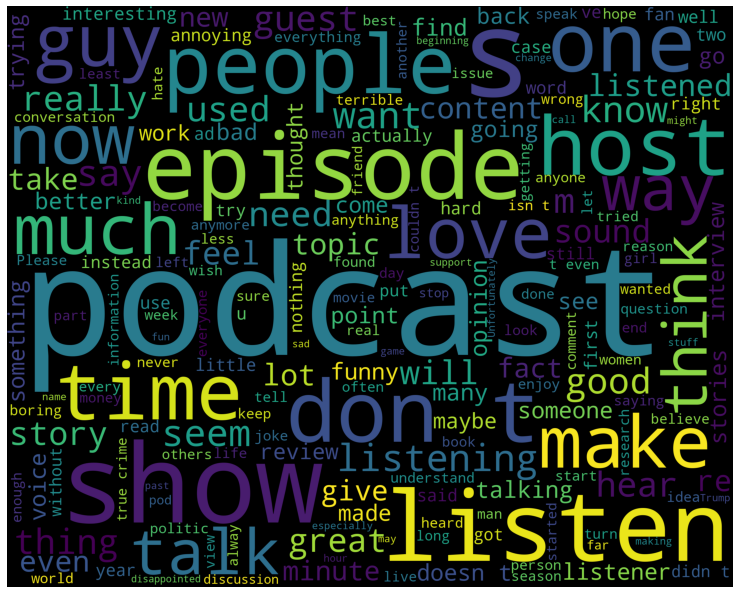

In [58]:
# Negatív szavak

print("Negative words")
wordcloud_draw(train_neg)

Neutral words


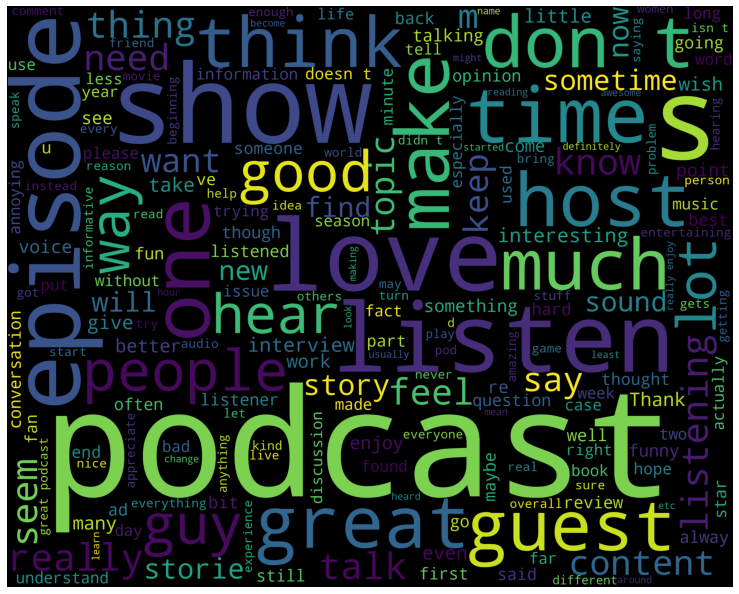

In [59]:
# Semleges szavak

print("Neutral words")
wordcloud_draw(train_neu)

In [61]:
# Tisztítás

comments = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.content.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    comments.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 2]
test_pos = test_pos['content']
test_neg = test[ test['sentiment'] == 0]
test_neg = test_neg['content']
test_neu = test[ test['sentiment'] == 1]
test_neu = test_neu['content']

In [63]:
# Kulcs szavak

def get_words_in_comments(comments):
    all = []
    for (words, sentiment) in comments:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_comments(comments))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

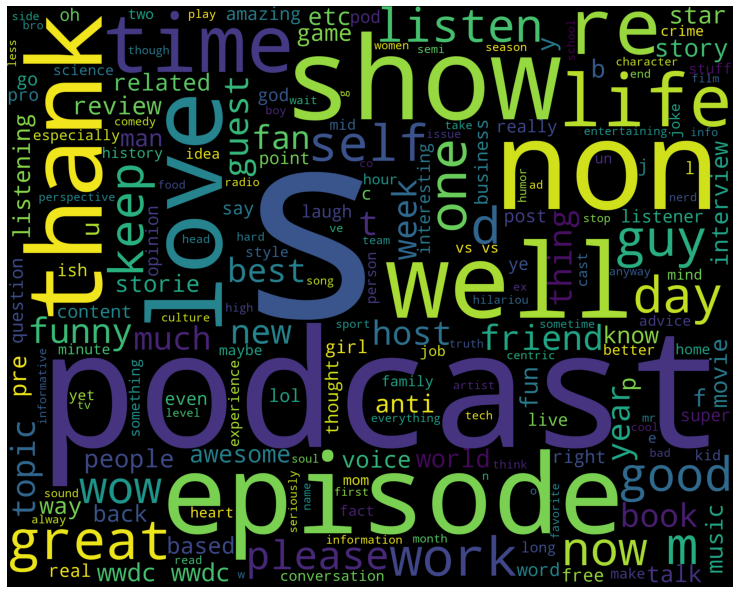

In [64]:
# Kulcs szavak

wordcloud_draw(w_features)

In [65]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,comments)
classifier = nltk.NaiveBayesClassifier.train(training_set)

KeyboardInterrupt: 

In [ ]:
# Test

neg_cnt = 0
pos_cnt = 0
neu_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 0): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 2): 
        pos_cnt = pos_cnt + 1
for obj in test_neu: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 1): 
        neu_cnt = neu_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))
print('[Neutral]: %s/%s '  % (len(test_neu),neu_cnt))